<a href="https://colab.research.google.com/github/ArnyWu/DeepGenerativeModels_HW3/blob/main/%E4%BD%BF%E7%94%A8_Seq2Seq_LSTM_%E8%88%87_Seq2Seq_VAE_%E7%94%9F%E6%88%90%E3%80%8C%E6%9C%AA%E4%BE%86%E5%AD%B8%E7%BF%92%E8%A1%8C%E7%82%BA%E5%BA%8F%E5%88%97%E3%80%8D%E6%95%B8%E6%93%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 載入資料

In [ ]:
import pandas as pd

# 讀取 CSV 檔
studentAssessment = pd.read_csv("studentAssessment.csv")

# 讀取 CSV 檔
studentInfo = pd.read_csv("studentInfo.csv")

# 讀取 CSV 檔
studentVle = pd.read_csv("studentVle.csv")

In [ ]:
studentAssessment

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


In [ ]:
studentInfo

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


In [ ]:
studentVle

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
...,...,...,...,...,...,...
10655275,GGG,2014J,675811,896943,269,3
10655276,GGG,2014J,675578,896943,269,1
10655277,GGG,2014J,654064,896943,269,3
10655278,GGG,2014J,654064,896939,269,1


In [ ]:
print(f"studentAssessment的columns：{studentAssessment.columns}")
print(f"studentInfo的columns：{studentInfo.columns}")
print(f"studentVle的columns：{studentVle.columns}")

studentAssessment的columns：Index(['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score'], dtype='object')
studentInfo的columns：Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result'],
      dtype='object')
studentVle的columns：Index(['code_module', 'code_presentation', 'id_student', 'id_site', 'date',
       'sum_click'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np

# 你的三個 DataFrame：
# studentAssessment, studentInfo, studentVle

# Step 1. 建立 week 欄位
studentVle["week"] = (studentVle["date"] // 7).astype(int)
studentAssessment["week"] = (studentAssessment["date_submitted"] // 7).astype(int)

# Step 2. 每週 clicks
clicks_df = (
    studentVle.groupby(["id_student", "week"])["sum_click"]
    .sum()
    .reset_index()
    .rename(columns={"sum_click": "clicks"})
)

# Step 3. 每週作業提交情況
submit_df = (
    studentAssessment.groupby(["id_student", "week"])
    .agg(
        submit_cnt=("id_assessment", "count"),
        avg_score_sofar=("score", "mean")
    )
    .reset_index()
)

submit_df["has_submit"] = (submit_df["submit_cnt"] > 0).astype(int)

# Step 4. 合併 clicks 與 submit 特徵
features = pd.merge(clicks_df, submit_df, on=["id_student", "week"], how="left")
features.fillna({"submit_cnt": 0, "avg_score_sofar": 0, "has_submit": 0}, inplace=True)

# Step 5. 計算 clicks_diff1（週差分）
features["clicks_diff1"] = features.groupby("id_student")["clicks"].diff().fillna(0)

# Step 6. 補全每位學生的週序列（避免缺週）
all_weeks = range(features["week"].min(), features["week"].max() + 1)
students = features["id_student"].unique()
full_index = pd.MultiIndex.from_product([students, all_weeks], names=["id_student", "week"])
features = features.set_index(["id_student", "week"]).reindex(full_index).reset_index()

# 缺失值補零
features.fillna(0, inplace=True)

# Step 7. 合併 studentInfo（靜態特徵，可用於補充分析）
final_df = pd.merge(features, studentInfo, on="id_student", how="left")

print(final_df.head(20))


    id_student  week  clicks  submit_cnt  avg_score_sofar  has_submit  \
0         6516    -4   110.0         0.0              0.0         0.0   
1         6516    -3    48.0         0.0              0.0         0.0   
2         6516    -2     2.0         0.0              0.0         0.0   
3         6516    -1    96.0         0.0              0.0         0.0   
4         6516     0   229.0         0.0              0.0         0.0   
5         6516     1    42.0         0.0              0.0         0.0   
6         6516     2    79.0         1.0             60.0         1.0   
7         6516     3   193.0         0.0              0.0         0.0   
8         6516     4    69.0         0.0              0.0         0.0   
9         6516     5    34.0         0.0              0.0         0.0   
10        6516     6    10.0         0.0              0.0         0.0   
11        6516     7    93.0         1.0             48.0         1.0   
12        6516     8    57.0         0.0           

In [ ]:
feature_cols = ["clicks", "submit_cnt", "has_submit", "avg_score_sofar", "clicks_diff1"]

# 選擇要的特徵
X = features[feature_cols]
y = features["clicks"]   # 目標變數 (未來 2 週)


In [ ]:
def create_sequences(df, feature_cols, past_window=4, future_window=2):
    """
    df: 前處理後的 DataFrame (包含 id_student, week, 特徵)
    feature_cols: 輸入特徵名稱 list
    past_window: 過去幾週當輸入
    future_window: 未來幾週當輸出
    """
    X, y = [], []

    for sid, group in df.groupby("id_student"):
        group = group.sort_values("week")
        data = group[feature_cols].values
        target = group["clicks"].values

        for i in range(len(group) - past_window - future_window + 1):
            X.append(data[i:i+past_window])
            y.append(target[i+past_window : i+past_window+future_window])

    return np.array(X), np.array(y)


In [ ]:
from sklearn.model_selection import train_test_split

# 先取得學生 ID 列表
students = features["id_student"].unique()

# 切分 70% train, 15% valid, 15% test
train_ids, test_ids = train_test_split(students, test_size=0.30, random_state=42)
valid_ids, test_ids = train_test_split(test_ids, test_size=0.50, random_state=42)

print(f"Train: {len(train_ids)} students, Valid: {len(valid_ids)}, Test: {len(test_ids)}")

# 依 ID 過濾 DataFrame
train_df = features[features["id_student"].isin(train_ids)]
valid_df = features[features["id_student"].isin(valid_ids)]
test_df  = features[features["id_student"].isin(test_ids)]

# 指定輸入特徵
feature_cols = ["clicks", "submit_cnt", "has_submit", "avg_score_sofar", "clicks_diff1"]

# 轉換成 (X, y)
X_train, y_train = create_sequences(train_df, feature_cols)
X_valid, y_valid = create_sequences(valid_df, feature_cols)
X_test,  y_test  = create_sequences(test_df, feature_cols)

print("Train shape:", X_train.shape, y_train.shape)
print("Valid shape:", X_valid.shape, y_valid.shape)
print("Test shape:",  X_test.shape,  y_test.shape)


Train: 18251 students, Valid: 3911, Test: 3912
Train shape: (693538, 4, 5) (693538, 2)
Valid shape: (148618, 4, 5) (148618, 2)
Test shape: (148656, 4, 5) (148656, 2)


# 固定隨機種子 + 特徵標準化

In [ ]:
import os, random, numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# 固定隨機種子
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

feature_cols = ["clicks", "submit_cnt", "has_submit", "avg_score_sofar", "clicks_diff1"]

# 產生序列 (若你已經有 X_train/y_train，可略過)
X_train, y_train = create_sequences(train_df, feature_cols, past_window=4, future_window=2)
X_valid, y_valid = create_sequences(valid_df, feature_cols, past_window=4, future_window=2)
X_test,  y_test  = create_sequences(test_df,  feature_cols, past_window=4, future_window=2)

# 標準化：fit on train，transform valid/test
scalers = []
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled  = X_test.copy()

# 對每個時間步同一組特徵用同一 scaler（簡潔做法：展平時間步一起 fit）
scaler = StandardScaler()
scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid_scaled = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
X_test_scaled  = scaler.transform(X_test.reshape(-1,  X_test.shape[-1])).reshape(X_test.shape)


# 建立與訓練 Seq2Seq LSTM

In [ ]:
from tensorflow.keras import layers, models, callbacks, optimizers, losses
import time

timesteps = X_train_scaled.shape[1]   # 4
n_features = X_train_scaled.shape[2]  # 5
hsize = 64

inputs = layers.Input(shape=(timesteps, n_features))
# Encoder
x = layers.LSTM(hsize, return_sequences=False, name="enc_lstm")(inputs)
# Decoder
x = layers.RepeatVector(2, name="repeat_future_2")(x)         # 產出2個未來步
x = layers.LSTM(hsize, return_sequences=True, name="dec_lstm")(x)
x = layers.TimeDistributed(layers.Dense(1), name="td_out")(x) # shape: (batch, 2, 1)
outputs = layers.Flatten(name="flatten_out")(x)               # shape: (batch, 2)

lstm_model = models.Model(inputs, outputs, name="Seq2Seq_LSTM")
lstm_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=losses.MeanSquaredError()
)

lstm_model.summary()

# 早停 + 最佳權重回復
es = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
start = time.time()
history = lstm_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=30, batch_size=128, verbose=1, callbacks=[es]
)
print("LSTM training time:", time.time() - start, "sec")

start = time.time()
y_pred_test = lstm_model.predict(X_test_scaled, batch_size=256, verbose=0)
print("LSTM inference time:", time.time() - start, "sec")

Model: "Seq2Seq_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm (LSTM)                 │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_future_2 (RepeatVector)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_lstm (LSTM)                 │ (None, 2, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_out (TimeDistributed)        │ (None, 2, 1)           │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_out (Flatten)           │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - loss: 6193.9824 - val_loss: 5074.0854
Epoch 2/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 69s 13ms/step - loss: 4911.1201 - val_loss: 4877.6587
Epoch 3/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 4775.3325 - val_loss: 4812.9639
Epoch 4/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 85s 14ms/step - loss: 4727.6484 - val_loss: 4783.5298
Epoch 5/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - loss: 4700.5117 - val_loss: 4765.9116
Epoch 6/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 4681.6787 - val_loss: 4752.9092
Epoch 7/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 4666.5659 - val_loss: 4743.5493
Epoch 8/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 4653.4180 - val_loss: 4736.1816
Epoch 9/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - loss: 4642.1309 - val_loss: 4730.7134
Epoch 10/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - loss: 4631.2095 - val_loss: 4727.2070
Epoch 11/30
5419/5419 ━━━━━━━━━━━━━━━━━

## 評估（MSE）與簡易視覺化

[LSTM] Test MSE: 4727.9459


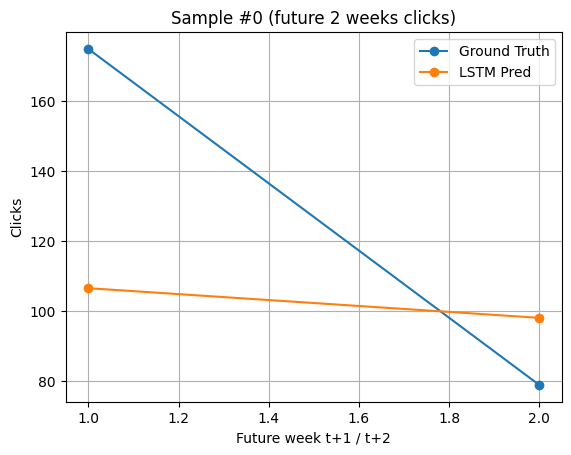

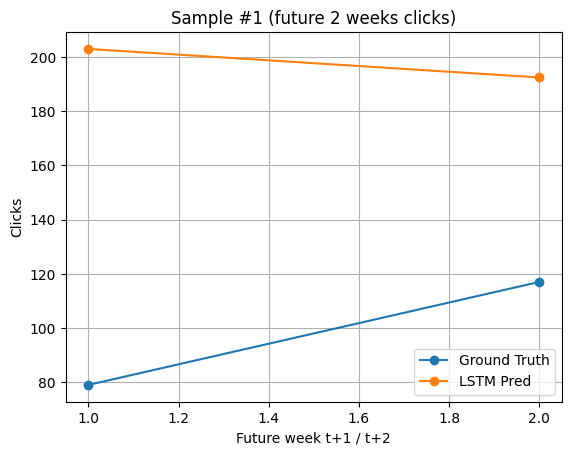

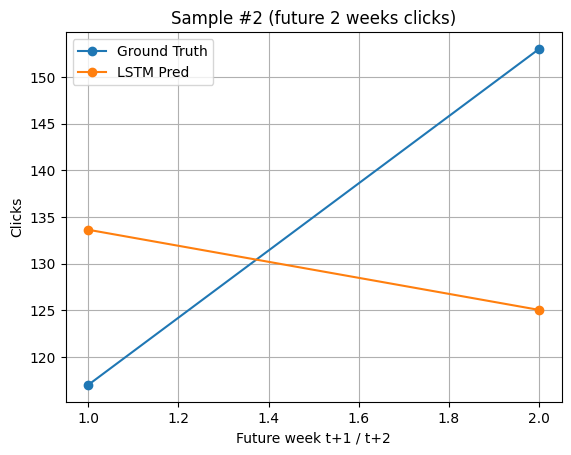

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# LSTM 單一路徑 MSE（整體平均）
y_pred_test = lstm_model.predict(X_test_scaled, batch_size=256, verbose=0)
lstm_mse = mean_squared_error(y_test.reshape(-1), y_pred_test.reshape(-1))
print(f"[LSTM] Test MSE: {lstm_mse:.4f}")

# 視覺化：挑幾筆樣本
def plot_samples(idx_list):
    for idx in idx_list:
        gt = y_test[idx]         # (2,)
        pr = y_pred_test[idx]    # (2,)
        plt.figure()
        plt.plot([1,2], gt, marker="o", label="Ground Truth")
        plt.plot([1,2], pr, marker="o", label="LSTM Pred")
        plt.title(f"Sample #{idx} (future 2 weeks clicks)")
        plt.xlabel("Future week t+1 / t+2")
        plt.ylabel("Clicks")
        plt.legend()
        plt.grid(True)
        plt.show()

# 範例：畫 3 筆
plot_samples([0, 1, 2])


# Seq2Seq VAE

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

latent_dim = 16   # 潛在維度
beta = 0.01       # KL loss 權重，可調整

# 自訂採樣層，順便把 KL loss 加進去
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(shape=tf.shape(mu))
        z = mu + tf.exp(0.5 * log_var) * eps
        # KLD loss
        kld = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1)
        )
        self.add_loss(beta * kld)   # 把 KL 項加入 loss
        return z

# ===== 建立 VAE =====
vae_inputs = layers.Input(shape=(timesteps, n_features))
# Encoder
e = layers.LSTM(hsize, return_sequences=False)(vae_inputs)
mu = layers.Dense(latent_dim)(e)
log_var = layers.Dense(latent_dim)(e)
z = Sampling()([mu, log_var])

# Decoder
d = layers.RepeatVector(2)(z)  # 未來 2 週
d = layers.LSTM(hsize, return_sequences=True)(d)
d = layers.TimeDistributed(layers.Dense(1))(d)
vae_outputs = layers.Flatten()(d)  # (batch, 2)

# Model
vae_model = models.Model(vae_inputs, vae_outputs, name="Seq2Seq_VAE")

# 只需要指定重建 loss (MSE)，KLD 已經在 Sampling.add_loss 內自動加入
vae_model.compile(optimizer=optimizers.Adam(1e-3), loss="mse")

vae_model.summary()


Model: "Seq2Seq_VAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 4, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     17,920 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │      1,040 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      1,040 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 2, 16)     │          0 │ sampling[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 2, 64)     │     20,736 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 2, 1)      │         65 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,801 (159.38 KB)

 Trainable params: 40,801 (159.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

start = time.time()
history_vae = vae_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=30,
    batch_size=128,
    callbacks=[es],
    verbose=1
)
print("VAE training time:", time.time() - start, "sec")

start = time.time()
vae_preds = vae_model.predict(X_test_scaled, batch_size=256, verbose=0)
print("VAE inference time:", time.time() - start, "sec")

Epoch 1/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - loss: 6205.7739 - val_loss: 5078.3501
Epoch 2/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 4913.3481 - val_loss: 4877.9077
Epoch 3/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 4773.5771 - val_loss: 4812.2505
Epoch 4/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 4725.2109 - val_loss: 4781.7568
Epoch 5/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 4699.8906 - val_loss: 4768.0391
Epoch 6/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - loss: 4684.1909 - val_loss: 4755.4619
Epoch 7/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 69s 13ms/step - loss: 4668.3311 - val_loss: 4745.1533
Epoch 8/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 4655.7637 - val_loss: 4739.7046
Epoch 9/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 4644.9087 - val_loss: 4732.1221
Epoch 10/30
5419/5419 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 4634.8960 - val_loss: 4735.7769
Epoch 11/30
5419/5419 ━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np

def vae_sample(model, X, N=20, batch_size=256):
    preds = []
    for _ in range(N):
        preds.append(model.predict(X, batch_size=batch_size, verbose=0))
    return np.stack(preds, axis=0)  # (N, batch, 2)

# 產生 20 條樣本
N = 20
samples = vae_sample(vae_model, X_test_scaled, N=N)
print(samples.shape)  # (20, 測試筆數, 2)


(20, 148656, 2)


In [ ]:
from sklearn.metrics import mean_squared_error

# Best-of-N MSE
bon_mse = []
for b in range(samples.shape[1]):  # 每個測試樣本
    cand = samples[:, b, :]        # (N, 2)
    gt   = y_test[b]               # (2,)
    mse_list = ((cand - gt)**2).mean(axis=1)
    bon_mse.append(mse_list.min())
bon_mse = np.mean(bon_mse)
print(f"[VAE] Best-of-{N} MSE: {bon_mse:.4f}")

# Diversity（樣本的標準差）
diversity = np.mean(np.std(samples, axis=0))  # 在 N 維度上求 std，再平均
print(f"[VAE] Diversity (std): {diversity:.4f}")

# Coverage（是否至少有一條樣本落在容忍範圍）
tol = np.std(y_train)  # 容忍區間 = 訓練集 clicks 的 std
cover_hits = []
for b in range(samples.shape[1]):
    cand = samples[:, b, :]
    gt   = y_test[b]
    ok = np.any(np.all(np.abs(cand - gt) <= tol, axis=1))
    cover_hits.append(1 if ok else 0)
coverage = np.mean(cover_hits)
print(f"[VAE] Coverage (tol={tol:.2f}): {coverage:.4f}")


[VAE] Best-of-20 MSE: 4700.0161
[VAE] Diversity (std): 0.2362
[VAE] Coverage (tol=83.30): 0.8624


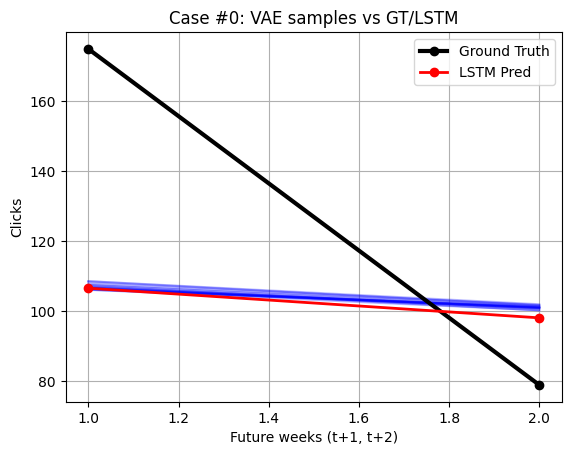

In [ ]:
import matplotlib.pyplot as plt

def plot_vae_samples(case_idx=0):
    plt.figure()
    # 畫 N 條 VAE 曲線（半透明）
    for i in range(samples.shape[0]):
        plt.plot([1,2], samples[i, case_idx, :], alpha=0.25, color="blue")
    # Ground Truth
    plt.plot([1,2], y_test[case_idx], marker="o", linewidth=3, label="Ground Truth", color="black")
    # LSTM 預測
    plt.plot([1,2], y_pred_test[case_idx], marker="o", linewidth=2, label="LSTM Pred", color="red")
    plt.title(f"Case #{case_idx}: VAE samples vs GT/LSTM")
    plt.xlabel("Future weeks (t+1, t+2)")
    plt.ylabel("Clicks")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_vae_samples(0)


# 總結

In [ ]:
import pandas as pd
import numpy as np


# ====== Step 1. 計算每個樣本的 LSTM / VAE 誤差 ======
# LSTM 預測已經有：y_pred_test
lstm_errors = np.mean((y_pred_test - y_test) ** 2, axis=1)   # (batch,)

# VAE 多樣本已經有：samples (N, batch, 2)
vae_errors = np.mean((samples - y_test[None, :, :]) ** 2, axis=2)  # (N, batch)
vae_best_errors = np.min(vae_errors, axis=0)  # (batch,)

# 差異 Δ
delta = lstm_errors - vae_best_errors

# Diversity per sample
vae_div = np.std(samples, axis=0).mean(axis=1)  # (batch,)

# ====== Step 2. Top-K 案例 (VAE >> LSTM) ======
topk_idx = np.argsort(delta)[-5:][::-1]  # Top 5
df_topk = pd.DataFrame({
    "idx": topk_idx,
    "LSTM_MSE": lstm_errors[topk_idx],
    "VAE_best_MSE": vae_best_errors[topk_idx],
    "Δ(LSTM-VAE)": delta[topk_idx],
    "y_true": [y_test[i].tolist() for i in topk_idx],
    "y_LSTM": [y_pred_test[i].tolist() for i in topk_idx],
    "y_VAE_best": [samples[np.argmin(vae_errors[:, i]), i, :].tolist() for i in topk_idx],
    "Diversity_std": vae_div[topk_idx]
})
print("=== Top-5 Regressed (VAE best >> LSTM) ===")
display(df_topk)

# ====== Step 3. Win-rate by Improvement Bucket ======
buckets = [
    ("VAE<<劣(>1000)", (-np.inf, -1000)),
    ("VAE劣(200~1000)", (-1000, -200)),
    ("VAE劣(50~200)", (-200, -50)),
    ("VAE劣(10~50)", (-50, -10)),
    ("VAE略劣(<10)", (-10, 0)),
    ("≈打平(±10)", (-10, 10)),
    ("VAE略勝(10~50)", (10, 50)),
    ("VAE小勝(50~200)", (50, 200)),
    ("VAE大勝(200~1000)", (200, 1000)),
    ("VAE>>大勝(>1000)", (1000, np.inf)),
]

bucket_results = []
for name, (low, high) in buckets:
    mask = (delta > low) & (delta <= high)
    count = np.sum(mask)
    ratio = count / len(delta)
    bucket_results.append((name, count, ratio))

df_bucket = pd.DataFrame(bucket_results, columns=["Improvement bucket", "count", "ratio"])
print("\n=== Win-rate by improvement bucket (Δ = LSTM MSE - VAE best MSE) ===")
display(df_bucket)

# ====== Step 4. 總結指標 ======
tau = np.median(lstm_errors)  # 門檻 = LSTM 每序列 MSE 中位數
coverage_hits = np.any(vae_errors <= tau, axis=0).astype(int)
coverage = coverage_hits.mean()

print("\n=========== 評估結果 (原始尺度) ===========")
print(f"LSTM  MSE (整體)   : {np.mean(lstm_errors):.4f}")
print(f"VAE   Best-of-N MSE: {np.mean(vae_best_errors):.4f}   (N={samples.shape[0]})")
print(f"VAE   Diversity(std): {np.mean(vae_div):.4f}")
print(f"VAE   Coverage(比例): {coverage:.4f}   (門檻 tau = LSTM 每序列 MSE 中位數 = {tau:.4f})")


=== Top-5 Regressed (VAE best >> LSTM) ===


,idx,LSTM_MSE,VAE_best_MSE,Δ(LSTM-VAE),y_true,y_LSTM,y_VAE_best,Diversity_std
0,26213,477448.105506,338739.226493,138708.879013,"[229.0, 999.0]","[275.85382080078125, 22.93600082397461]","[324.5067138671875, 181.46900939941406]",21.334541
1,98803,290348.582939,192499.328255,97849.254683,"[1004.0, 877.0]","[412.76495361328125, 396.2315673828125]","[472.5735778808594, 556.711669921875]",4.020551
2,26215,145033.976214,69645.196167,75388.780046,"[0.0, 0.0]","[430.9682922363281, 323.0081787109375]","[283.19879150390625, 243.0819549560547]",15.385843
3,98801,566408.072862,493982.095356,72425.977506,"[1232.0, 1193.0]","[455.66021728515625, 464.91162109375]","[473.7547912597656, 550.3271484375]",0.278272
4,77081,76136.177619,10855.989663,65280.187956,"[462.0, 213.0]","[93.73322296142578, 83.9576187133789]","[314.8753662109375, 204.856201171875]",6.367389



=== Win-rate by improvement bucket (Δ = LSTM MSE - VAE best MSE) ===


,Improvement bucket,count,ratio
0,VAE<<劣(>1000),3726,0.025065
1,VAE劣(200~1000),10181,0.068487
2,VAE劣(50~200),12842,0.086387
3,VAE劣(10~50),10792,0.072597
4,VAE略劣(<10),5405,0.036359
5,≈打平(±10),46648,0.313798
6,VAE略勝(10~50),21062,0.141683
7,VAE小勝(50~200),26475,0.178096
8,VAE大勝(200~1000),12821,0.086246
9,VAE>>大勝(>1000),4109,0.027641



=========== 評估結果 (原始尺度) ===========
LSTM  MSE (整體)   : 4727.9459
VAE   Best-of-N MSE: 4700.0161   (N=20)
VAE   Diversity(std): 0.2362
VAE   Coverage(比例): 0.5173   (門檻 tau = LSTM 每序列 MSE 中位數 = 371.1543)
